# Data Cleaning

In [65]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [66]:
#import csv file
startup_data = pd.read_csv('ks-projects-201801.csv')
startup_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [67]:
print("Data type : ", type(startup_data))
print("Data dims : ", startup_data.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (378661, 15)


In [68]:
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [69]:
pd.unique(startup_data.state)

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [70]:
startup_data.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [71]:
startup_data.drop(columns=['name','ID','category','usd pledged','currency','goal','pledged'], axis = 1, inplace = True)

In [72]:
startup_data = startup_data[startup_data['state'].isin(['failed', 'successful'])]
startup_data.sample(10)

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
82684,Fashion,2017-06-12,2017-05-12 12:09:37,successful,281,US,38269.00,8000.00
231899,Food,2015-04-30,2015-03-31 17:57:11,failed,0,US,0.00,10000.00
47204,Games,2012-03-21,2012-02-27 14:25:40,successful,191,US,7015.51,2000.00
291865,Art,2015-07-14,2015-06-14 16:31:53,failed,0,US,0.00,200000.00
50917,Food,2011-08-17,2011-07-18 23:56:59,successful,76,US,5415.00,5000.00
183696,Games,2013-08-11,2013-07-08 16:29:29,successful,597,US,23267.25,15000.00
3310,Games,2017-03-04,2017-02-01 22:57:51,failed,21,US,2176.00,50000.00
57025,Publishing,2015-07-16,2015-06-01 21:00:20,failed,15,US,515.00,12000.00
3493,Publishing,2016-02-16,2016-01-17 20:23:03,failed,0,IT,0.00,2219.19
319710,Games,2012-10-21,2012-09-21 04:32:29,successful,60,US,2419.00,2000.00


1. Here, we can see the various types of status of the startups but we are concerned  only with successful and failed startups as we are predicting this category.
2. Thus we remove all other categories such as 'canceled', 'live', 'undefined', 'suspended'  and only keep the remaining two.
3. We examine the null values and see that columns 'name' and 'usd pledged' have null values but we do not need to correct this as these columns are unnecessary in our problem so we will ultimately drop them.
4. We remove all unnecesary columns that are not going to help predict the success of the startup such as 'id', 'name' etc.


In [73]:
startup_data = startup_data.assign(state_num = (startup_data['state'] == 'successful').astype(int))
#startup_data.drop(columns=['state'], axis = 1, inplace = True)
startup_data

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_num
0,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,0
1,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,0
2,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,0
3,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,0
5,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,1
...,...,...,...,...,...,...,...,...,...
378654,Food,2017-04-19,2017-03-20 22:08:22,failed,4,US,154.0,6500.00,0
378657,Film & Video,2011-07-19,2011-06-22 03:35:14,failed,5,US,155.0,1500.00,0
378658,Film & Video,2010-08-16,2010-07-01 19:40:30,failed,1,US,20.0,15000.00,0
378659,Technology,2016-02-13,2016-01-13 18:13:53,failed,6,US,200.0,15000.00,0


In [74]:

country_encoder = LabelEncoder()
main_category_encoder = LabelEncoder()

startup_data['encoded_country'] = country_encoder.fit_transform(startup_data['country'])
startup_data['encoded_main_category'] = main_category_encoder.fit_transform(startup_data['main_category'])

startup_data

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_num,encoded_country,encoded_main_category
0,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,0,9,12
1,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,0,22,6
2,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,0,22,6
3,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,0,22,10
5,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,1,22,7
...,...,...,...,...,...,...,...,...,...,...,...
378654,Food,2017-04-19,2017-03-20 22:08:22,failed,4,US,154.0,6500.00,0,22,7
378657,Film & Video,2011-07-19,2011-06-22 03:35:14,failed,5,US,155.0,1500.00,0,22,6
378658,Film & Video,2010-08-16,2010-07-01 19:40:30,failed,1,US,20.0,15000.00,0,22,6
378659,Technology,2016-02-13,2016-01-13 18:13:53,failed,6,US,200.0,15000.00,0,22,13


In [75]:
startup_data.deadline = pd.to_datetime(startup_data.deadline)
startup_data.launched = pd.to_datetime(startup_data.launched)
startup_data

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_num,encoded_country,encoded_main_category
0,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,0,9,12
1,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,0,22,6
2,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,0,22,6
3,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,0,22,10
5,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,1,22,7
...,...,...,...,...,...,...,...,...,...,...,...
378654,Food,2017-04-19,2017-03-20 22:08:22,failed,4,US,154.0,6500.00,0,22,7
378657,Film & Video,2011-07-19,2011-06-22 03:35:14,failed,5,US,155.0,1500.00,0,22,6
378658,Film & Video,2010-08-16,2010-07-01 19:40:30,failed,1,US,20.0,15000.00,0,22,6
378659,Technology,2016-02-13,2016-01-13 18:13:53,failed,6,US,200.0,15000.00,0,22,13


In [76]:
startup_data['Duration_of_campaign(days)'] = (startup_data['deadline'] - startup_data.launched).dt.days 

startup_data['Deadline(y)']=pd.to_datetime(startup_data.deadline).dt.year 
startup_data['Launched(y)']=pd.to_datetime(startup_data.launched).dt.year 

startup_data['Launched(m)']=pd.to_datetime(startup_data.launched).dt.month
startup_data['Deadline(m)']=pd.to_datetime(startup_data.deadline).dt.month 
startup_data.drop(columns=['deadline','launched'], axis = 1, inplace = True)
startup_data

,main_category,state,backers,country,usd_pledged_real,usd_goal_real,state_num,encoded_country,encoded_main_category,Duration_of_campaign(days),Deadline(y),Launched(y),Launched(m),Deadline(m)
0,Publishing,failed,0,GB,0.0,1533.95,0,9,12,58,2015,2015,8,10
1,Film & Video,failed,15,US,2421.0,30000.00,0,22,6,59,2017,2017,9,11
2,Film & Video,failed,3,US,220.0,45000.00,0,22,6,44,2013,2013,1,2
3,Music,failed,1,US,1.0,5000.00,0,22,10,29,2012,2012,3,4
5,Food,successful,224,US,52375.0,50000.00,1,22,7,34,2016,2016,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,Food,failed,4,US,154.0,6500.00,0,22,7,29,2017,2017,3,4
378657,Film & Video,failed,5,US,155.0,1500.00,0,22,6,26,2011,2011,6,7
378658,Film & Video,failed,1,US,20.0,15000.00,0,22,6,45,2010,2010,7,8
378659,Technology,failed,6,US,200.0,15000.00,0,22,13,30,2016,2016,1,2


1. As 'state' is a categorical variable, we need to convert this into numerical by assigning 'successful' as 1 and 'failed' as 0 in a new column named 'state_num'. We then drop the original state column.
2. We then use LabelEncoder function from scikit-learn to encode categorical columns in the DataFrame startup_data. Then, it initializes LabelEncoder objects for each categorical column and fits them to the respective columns. After fitting, it transforms the columns into encoded numerical values. Finally, it adds new columns to the DataFrame (encoded_country and encoded_main_category) to store the encoded data, leaving the original columns (country and main_category) intact.
3. Then we convert the deadline and launched columns in the startup_data DataFrame to datetime objects, enabling easier manipulation and analysis of date and time data using to_datetime functions
4. We then calculate the duration of the campaign by subtracting the deadline and launched dates for easy manipulations and analysis.
5. We also convert the datetime variables into seperate variables of Deadline(y),Launched(y),Launched(m),Deadline(m) which show the respective years and months of the data, and then we drop the original deadline and launched columns.






# EDA

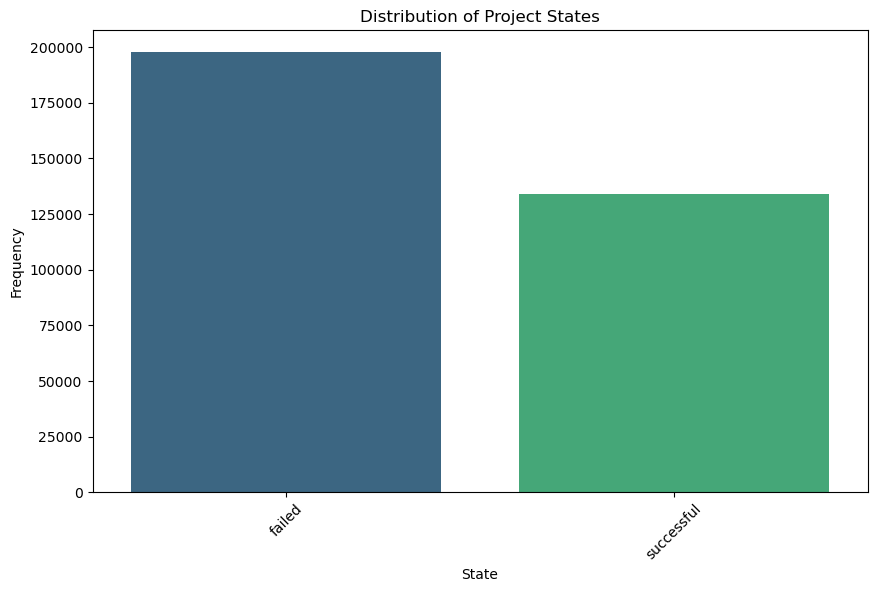

In [77]:
state_counts = startup_data['state'].value_counts()

plt.figure(figsize=(10, 6))
sb.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')
plt.title('Distribution of Project States')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()

# Basic Exploratory Data Analysis

We came up with some hypotheses regarding some factors that might affect whether a kickstarter project will be successful. We will explore the statistics regarding these factors to test our hypothesis

Fixed Factors: Factors that are determined from the beginning
1) The lower the goal amount, the easier it is to acheive it and be successful.
2) The longer the 'fundraising' duration, the more likely it is to succeed.
3) Certain categories are more likely to succeed than others.
4) Certain countries might affect success of project.

Variable Factors: Factors that you will only find out at the end of the campaign
1) Backers
2) Real Pledged Amount

When we initially plotted a box plot for state vs numerical values, we realise there were a lot of outliers. So we removed the outliers for each factor.

We do this by finding absolute z-score which indicates the standard deviation of each data from the mean and then filtering data with more than z-score of 3 which are considered outliers.

In [78]:
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   main_category               331675 non-null  object 
 1   state                       331675 non-null  object 
 2   backers                     331675 non-null  int64  
 3   country                     331675 non-null  object 
 4   usd_pledged_real            331675 non-null  float64
 5   usd_goal_real               331675 non-null  float64
 6   state_num                   331675 non-null  int32  
 7   encoded_country             331675 non-null  int32  
 8   encoded_main_category       331675 non-null  int32  
 9   Duration_of_campaign(days)  331675 non-null  int64  
 10  Deadline(y)                 331675 non-null  int64  
 11  Launched(y)                 331675 non-null  int64  
 12  Launched(m)                 331675 non-null  int64  
 13  Deadline(m)   

# Data Analysis 1: Goal Amount(Numerical)

We cloned the data to focus on hypothesis 1, goal amount vs state

In [79]:
goal_amount = startup_data

In [80]:
#Removing Outliers
z_goal = np.abs(stats.zscore(goal_amount['usd_goal_real']))
threshold = 3
outliers_goal = goal_amount[z_goal > threshold]
goal_amount = goal_amount.drop(outliers_goal.index)

<Axes: xlabel='usd_goal_real', ylabel='state'>

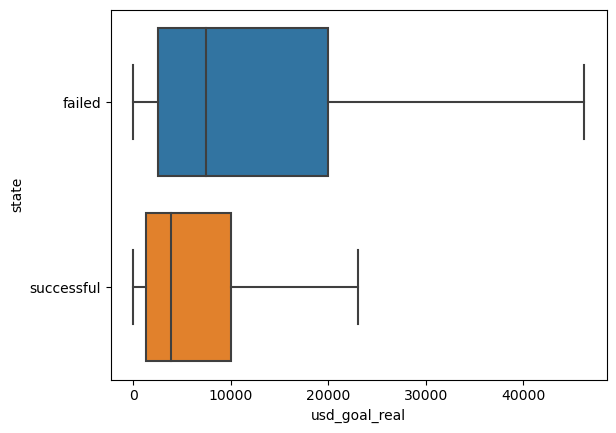

In [81]:
#In the following code, we plottted the box plot for goal amount vs state
sb.boxplot(data=goal_amount, x="usd_goal_real", y="state", showfliers = False)

In [82]:
print("Mean Goal Amounts:")
print(goal_amount.groupby('state')['usd_goal_real'].mean())

print("\nMedian Goal Amounts:")
print(goal_amount.groupby('state')['usd_goal_real'].median())


Mean Goal Amounts:
state
failed        30235.153082
successful     9532.853357
Name: usd_goal_real, dtype: float64

Median Goal Amounts:
state
failed        7500.00
successful    3837.74
Name: usd_goal_real, dtype: float64


Successful projects tend to have a significantly lower goal amounts on average compared to failed projects. The median values (less affected by outliers) highlights this point, showing that a typical successful project has a goal of about half or less than half of a failed project. <br>
Lets further examine the relationship

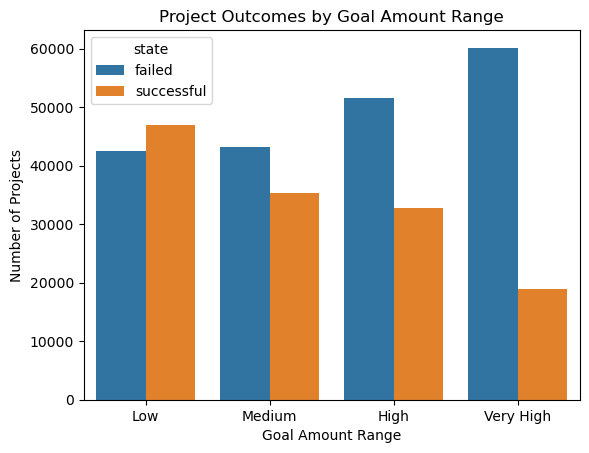

In [83]:
goal_amount['goal_range'] = pd.qcut(goal_amount['usd_goal_real'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

sb.countplot(data=goal_amount, x='goal_range', hue='state')
plt.xlabel('Goal Amount Range')
plt.ylabel('Number of Projects')
plt.title('Project Outcomes by Goal Amount Range')
plt.show()


There is a certain relationship where there is a higher number of failure when the goal amount is higher, and there is a higher amount of success when the goal amount is lower. <br>
Lets take a closer look at the success rate of the project by their goal amount range

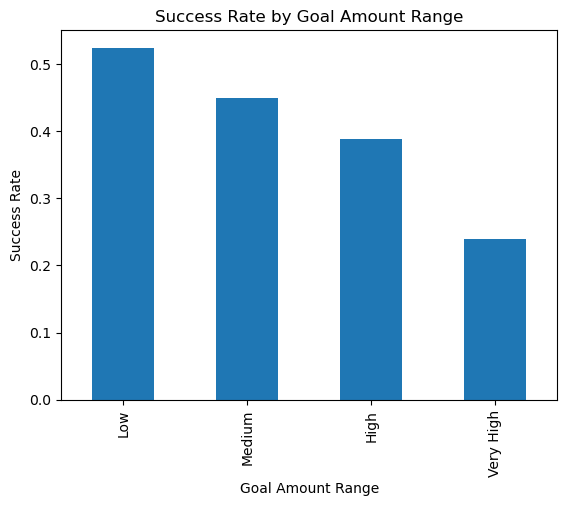

In [84]:
# Calculate success rate
success_rate = goal_amount.pivot_table(index='goal_range', columns='state', aggfunc='size', fill_value=0)
success_rate['success_rate'] = success_rate['successful'] / (success_rate['successful'] + success_rate['failed'])

# Plot
success_rate['success_rate'].plot(kind='bar')
plt.xlabel('Goal Amount Range')
plt.ylabel('Success Rate')
plt.title('Success Rate by Goal Amount Range')
plt.show()


From evidence, we could possibly conclude that the success of a kickstarter project could highly depend on the goal amonut, where if the goal is lower, the success rate tends to be higher.

# Data Analysis 2: Duration(Numerical)

We cloned the data to focus on hypothesis 2, duration vs state

In [85]:
duration = startup_data

In [86]:
#Removing Outliers
z_duration = np.abs(stats.zscore(duration['Duration_of_campaign(days)']))
threshold = 3
outliers_duration = duration[z_duration > threshold]
duration = duration.drop(outliers_duration.index)

<Axes: xlabel='Duration_of_campaign(days)', ylabel='state'>

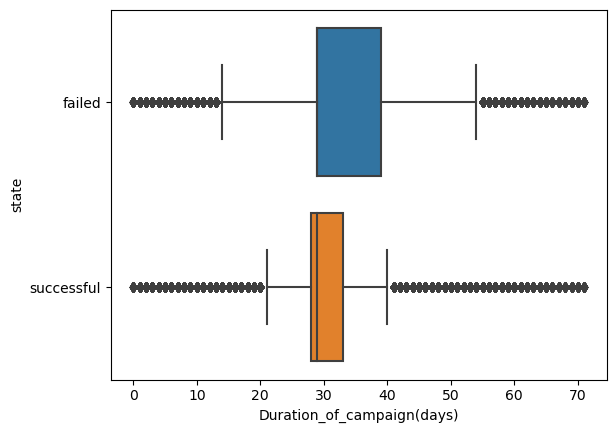

In [87]:
#In the following code, we plottted the box plot for duration vs state
sb.boxplot(data=duration, x="Duration_of_campaign(days)", y="state", showfliers = True)

In [88]:
print("Mean Goal Amounts:")
print(duration.groupby('state')['Duration_of_campaign(days)'].mean())

print("\nMedian Goal Amounts:")
print(duration.groupby('state')['Duration_of_campaign(days)'].median())

Mean Goal Amounts:
state
failed        33.641704
successful    30.717900
Name: Duration_of_campaign(days), dtype: float64

Median Goal Amounts:
state
failed        29.0
successful    29.0
Name: Duration_of_campaign(days), dtype: float64


Projects that failed has an average duration of about 34 days and projects that are successful have about 31 days. This suggests that projects that are within a months time are usually more successful. In fact, Kickstarter website states that there is a 60days limit to the campaigns, and they have found that projects lasting any longer than 60 days are rarely successful. They also recommend to set the duration to run for 30 days or less.<br><br>
we have to, however, keep in mind that there is a lot of outliers

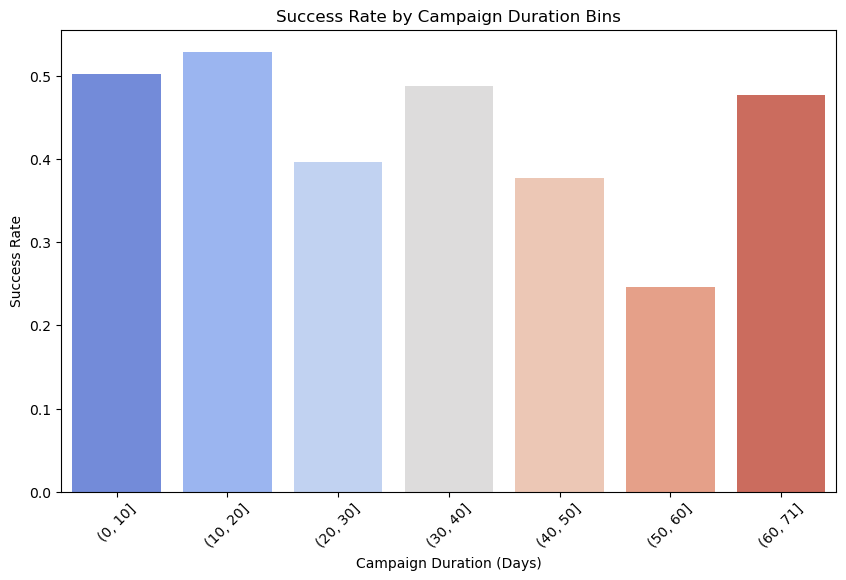

,Duration_Bins,Success_Rate
0,"(0, 10]",0.501689
1,"(10, 20]",0.528865
2,"(20, 30]",0.396357
3,"(30, 40]",0.487524
4,"(40, 50]",0.376670
5,"(50, 60]",0.246000
6,"(60, 71]",0.477419


In [89]:
# Binning the campaign duration into ranges for better analysis
duration['Duration_Bins'] = pd.cut(duration['Duration_of_campaign(days)'], bins=[0, 10, 20, 30, 40, 50, 60, duration['Duration_of_campaign(days)'].max()])

# Calculating success rates within each bin
success_rate_by_duration = duration.groupby('Duration_Bins').apply(lambda x: x[x['state'] == 'successful'].shape[0] / x.shape[0]).reset_index(name='Success_Rate')

# Plotting
plt.figure(figsize=(10, 6))
sb.barplot(data=success_rate_by_duration, x='Duration_Bins', y='Success_Rate', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Success Rate by Campaign Duration Bins')
plt.xlabel('Campaign Duration (Days)')
plt.ylabel('Success Rate')
plt.show()

success_rate_by_duration


# Data Analysis 3: Backers(Numberical)

We cloned the data to focus on hypothesis 3, backers vs state

In [90]:
backers = startup_data

In [91]:
#Removing Outliers
z_backers = np.abs(stats.zscore(backers['backers']))
threshold = 3
outliers_backers = backers[z_duration > threshold]
backers = backers.drop(outliers_duration.index)

<Axes: xlabel='backers', ylabel='state'>

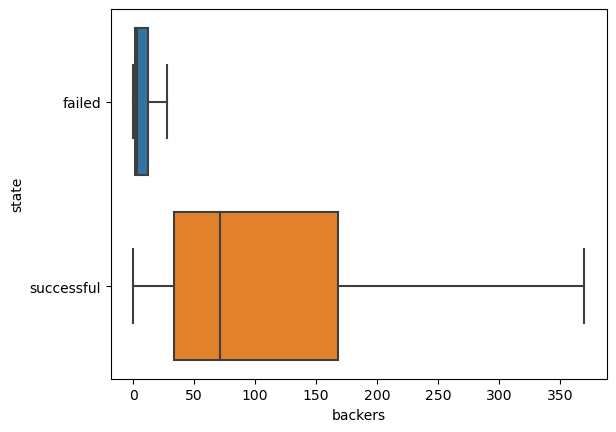

In [92]:
#In the following code, we plottted the box plot for backers vs state
sb.boxplot(data=backers, x="backers", y="state", showfliers = False)

In [93]:
print("Mean Number of Backers:")
print(backers.groupby('state')['backers'].mean())

print("\nMedian Number of Backers:")
print(backers.groupby('state')['backers'].median())


Mean Number of Backers:
state
failed         16.489126
successful    265.326972
Name: backers, dtype: float64

Median Number of Backers:
state
failed         3.0
successful    71.0
Name: backers, dtype: float64


The data is showing that the project would be more successful if there are more backers, which makes sense, now lets look at the success to see the correlation

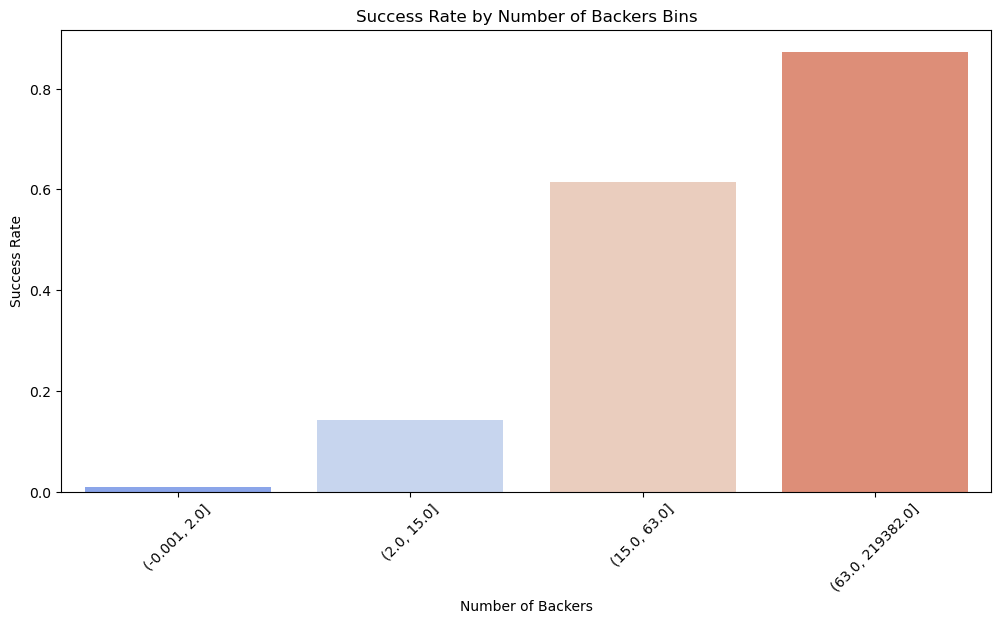

In [94]:
# Binning the number of backers into ranges for easier analysis
backers['Backers_Bins'] = pd.qcut(backers['backers'], q=4, duplicates='drop')  # Adjust 'q' based on distribution

# Calculating success rates within each bin
success_rate_by_backers = backers.groupby('Backers_Bins')['state'].apply(lambda x: (x == 'successful').mean()).reset_index(name='Success_Rate')

# Plotting
plt.figure(figsize=(12, 6))
sb.barplot(data=success_rate_by_backers, x='Backers_Bins', y='Success_Rate', palette='coolwarm')
plt.title('Success Rate by Number of Backers Bins')
plt.xlabel('Number of Backers')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.show()


# Data Analysis 4: Pledged Amount(Numberical)

We cloned the data to focus on hypothesis 4, pledge amount vs state

In [95]:
pledge = startup_data

In [96]:
z_pledge = np.abs(stats.zscore(backers['usd_pledged_real']))
threshold = 3
outliers_pledge = backers[z_pledge > threshold]
pledge = pledge.drop(outliers_duration.index)

<Axes: xlabel='usd_pledged_real', ylabel='state'>

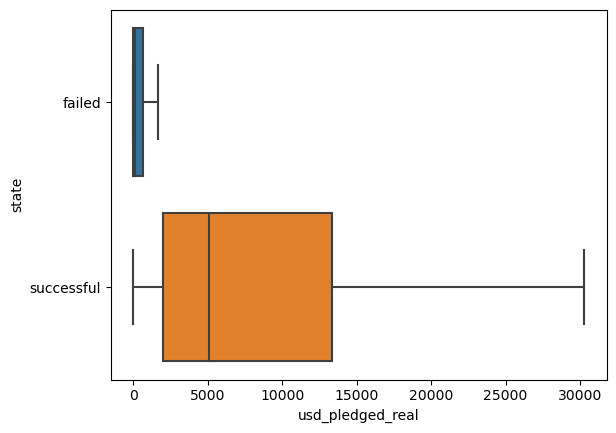

In [97]:
#In the following code, we plottted the box plot for backers vs state
sb.boxplot(data=pledge, x="usd_pledged_real", y="state", showfliers = False)

In [98]:
print("Mean Number of Backers:")
print(pledge.groupby('state')['usd_pledged_real'].mean())

print("\nMedian Number of Backers:")
print(pledge.groupby('state')['usd_pledged_real'].median())


Mean Number of Backers:
state
failed         1326.816298
successful    22790.375035
Name: usd_pledged_real, dtype: float64

Median Number of Backers:
state
failed         100.0
successful    5114.0
Name: usd_pledged_real, dtype: float64


Data over here is also showing that if there is a higher amount pledge, the project tend to be more successful. 

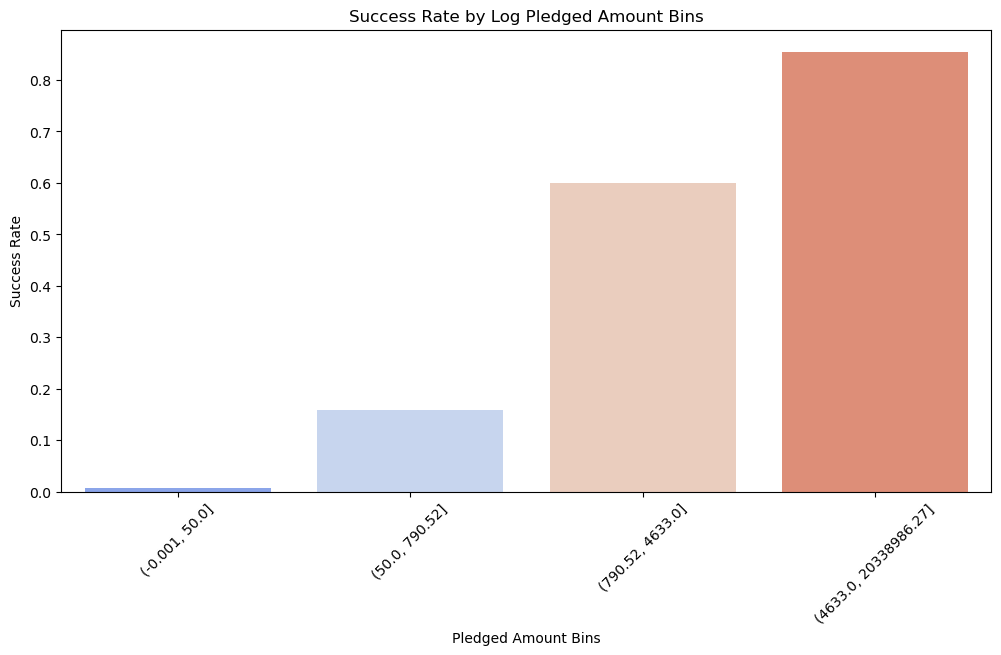

In [99]:
pledge['Pledged_Bins'] = pd.qcut(pledge['usd_pledged_real'], q=4, duplicates='drop')

success_rate_by_pledged = pledge.groupby('Pledged_Bins')['state'].apply(lambda x: (x == 'successful').mean()).reset_index(name='Success_Rate')

plt.figure(figsize=(12, 6))
sb.barplot(data=success_rate_by_pledged, x='Pledged_Bins', y='Success_Rate', palette='coolwarm')
plt.title('Success Rate by Log Pledged Amount Bins')
plt.xlabel('Pledged Amount Bins')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.show()


# Data Analysis 5: Categories(Categorical)

We cloned the data to focus on hypothesis 5, category vs state

In [100]:
category = startup_data

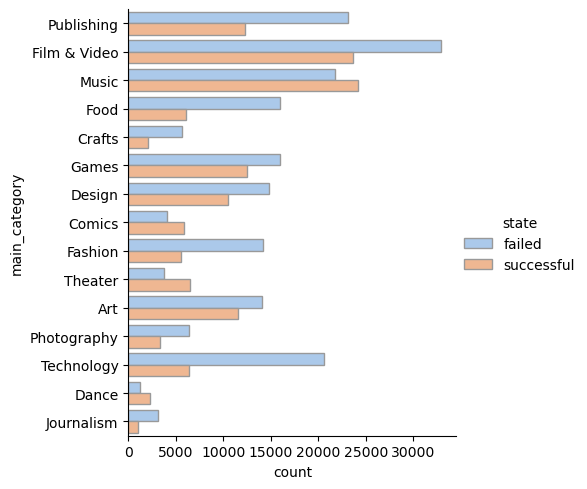

In [101]:
sb.catplot(data=category, y="main_category", hue="state", kind="count",palette="pastel", edgecolor=".6",)

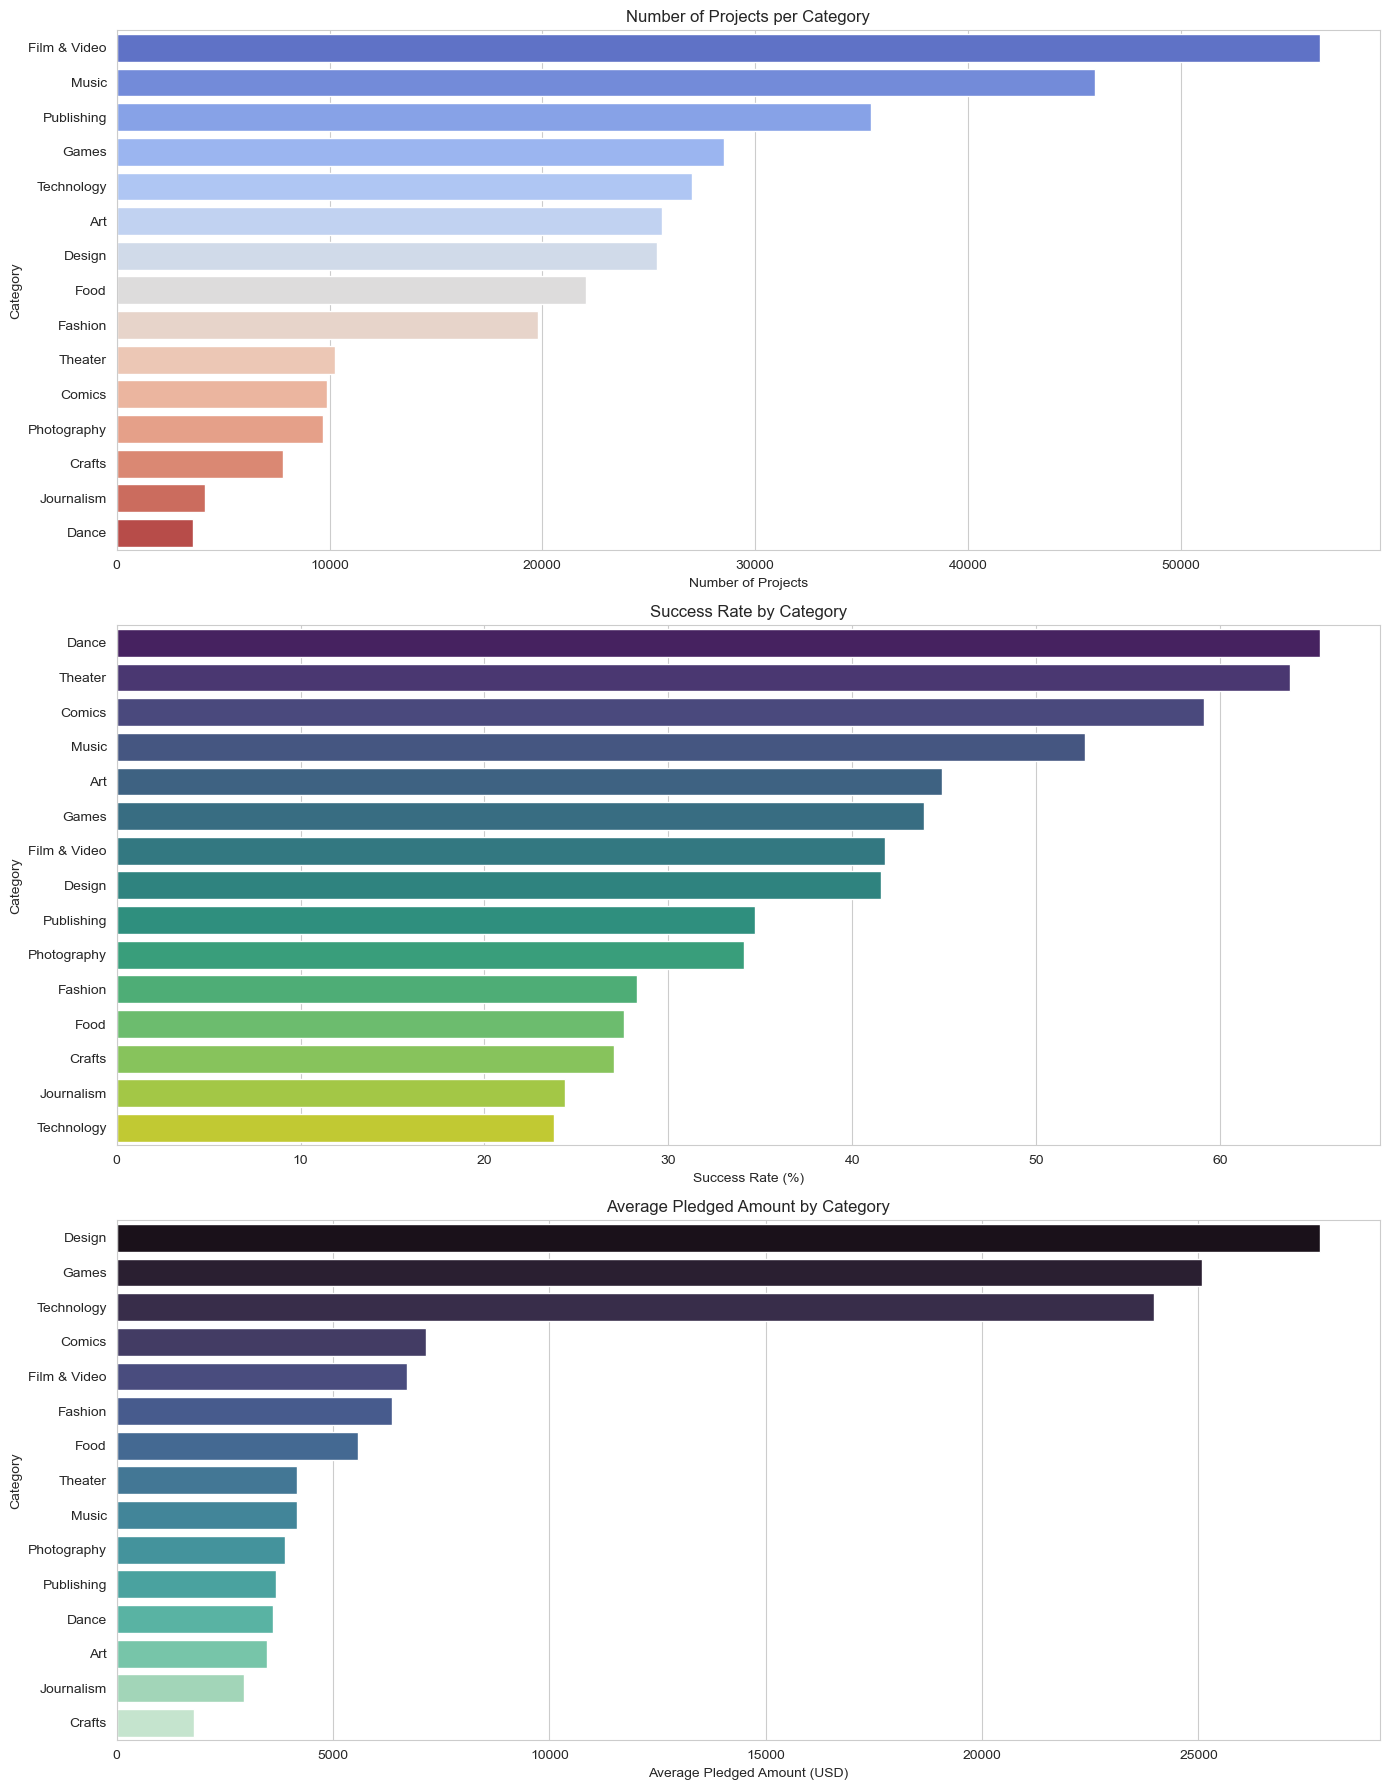

In [163]:
# Set the aesthetic style of the plots
sb.set_style("whitegrid")

# 1. Distribution of projects across different categories
category_counts = category['main_category'].value_counts()

# 2. Success rate (number of successful projects vs total projects) per category
success_counts = category[category['state'] == 'successful']['main_category'].value_counts()
total_counts = category['main_category'].value_counts()
success_rate = (success_counts / total_counts * 100).sort_values(ascending=False)

# 3. Average pledged amount by category
average_pledged = category.groupby('main_category')['usd_pledged_real'].mean().sort_values(ascending=False)

# Plotting all the figures
plt.figure(figsize=(14, 18))

plt.subplot(3, 1, 1)
sb.barplot(y=category_counts.index, x=category_counts.values, palette='coolwarm')
plt.title('Number of Projects per Category')
plt.xlabel('Number of Projects')
plt.ylabel('Category')

plt.subplot(3, 1, 2)
sb.barplot(y=success_rate.index, x=success_rate.values, palette='viridis')
plt.title('Success Rate by Category')
plt.xlabel('Success Rate (%)')
plt.ylabel('Category')

plt.subplot(3, 1, 3)
sb.barplot(y=average_pledged.index, x=average_pledged.values, palette='mako')
plt.title('Average Pledged Amount by Category')
plt.xlabel('Average Pledged Amount (USD)')
plt.ylabel('Category')

plt.tight_layout()
plt.show()


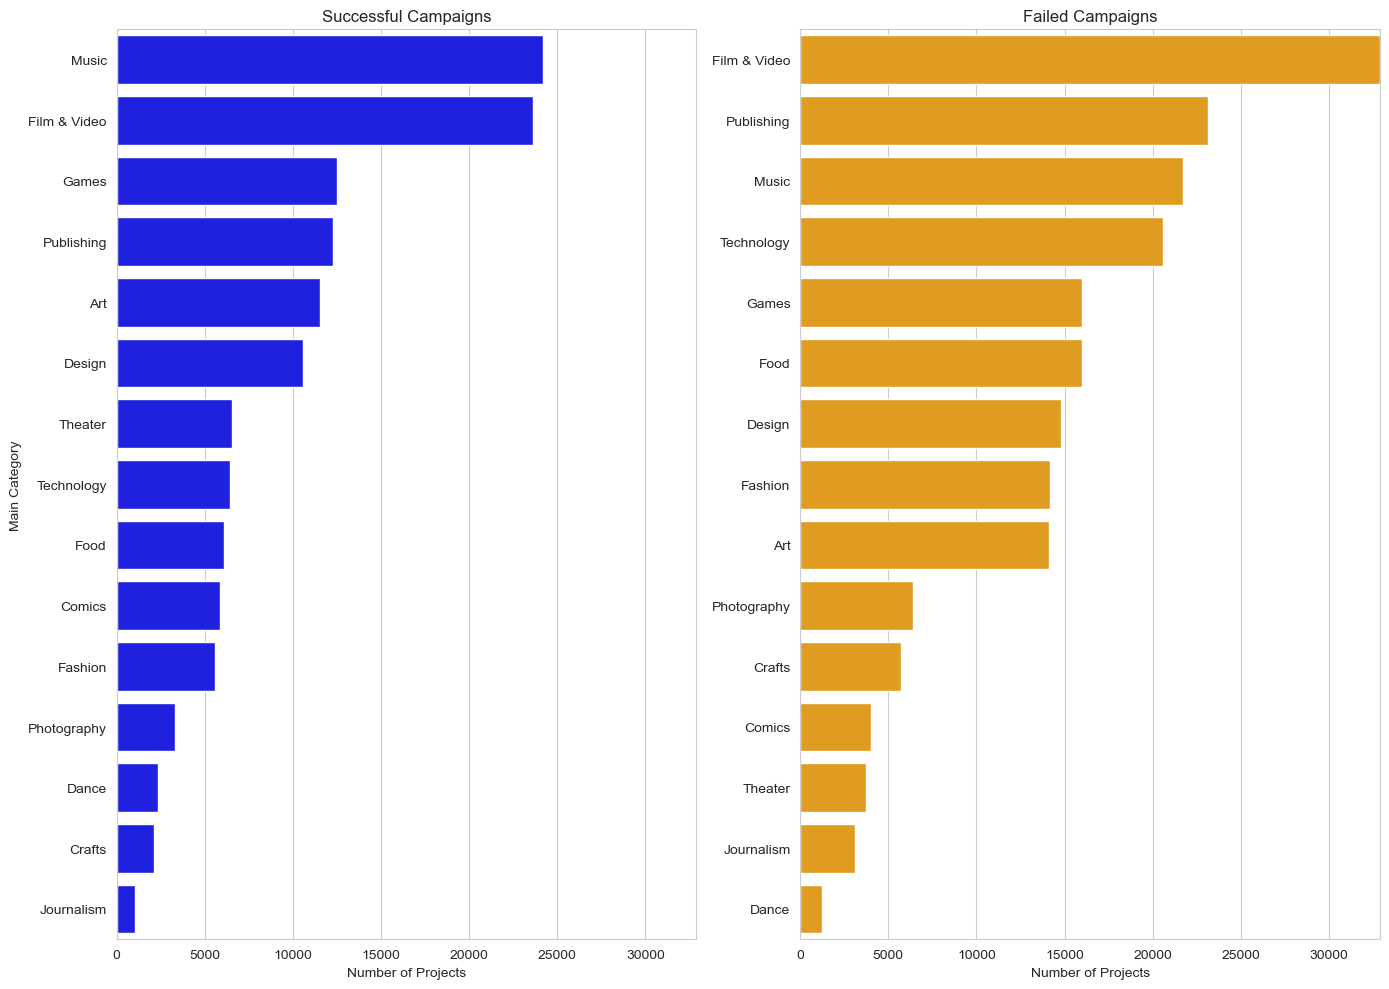

In [187]:
success_failures = category.groupby(['main_category', 'state']).size().unstack(fill_value=0)
success_failures['successful'] = success_failures['successful'].fillna(0)
success_failures['failed'] = success_failures['failed'].fillna(0)

# Sort the categories by the number of successful projects in descending order
sorted_categories_success = success_failures['successful'].sort_values(ascending=False).index
sorted_categories_failure = success_failures['failed'].sort_values(ascending=False).index

# Sorting the dataframe according to the sorted categories
success_sorted = success_failures.loc[sorted_categories_success]
failures_sorted = success_failures.loc[sorted_categories_failure]


plt.figure(figsize=(14, 10))

# Plot for successful campaigns
plt.subplot(1, 2, 1)
sns.barplot(x=success_failures.loc[sorted_categories_success]['successful'], y=success_sorted.index, color='blue', orient='h')
plt.title('Successful Campaigns')
plt.xlabel('Number of Projects')
plt.ylabel('Main Category')

# Plot for failed campaigns
plt.subplot(1, 2, 2)
sns.barplot(x=success_failures.loc[sorted_categories_failure]['failed'], y=failures_sorted.index, color='orange', orient='h')
plt.title('Failed Campaigns')
plt.xlabel('Number of Projects')
plt.ylabel('')

# Set the x-limits to be equal for comparison
max_limit = max(success_failures_sorted['successful'].max(), success_failures_sorted['failed'].max())
plt.subplot(1, 2, 1).set_xlim(0, max_limit)
plt.subplot(1, 2, 2).set_xlim(0, max_limit)

# Improve layout to avoid overlapping
plt.tight_layout()
plt.show()


# Data Analysis 6: Categories(Categorical)

We cloned the data to focus on hypothesis 6, country vs state

In [102]:
country = startup_data

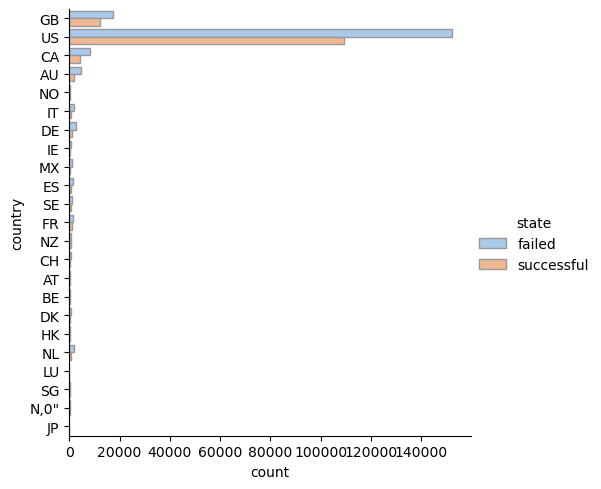

In [103]:
sb.catplot(data=country, y="country", hue="state", kind="count",palette="pastel", edgecolor=".6",)

We were able to form some insights from our initial exploratory analysis.
1) Successful kickstarters tend to have lower goal amounts
2) The 'sweet spot' duration for successful kickstarter is between 20 to 40 days
3) Successful kickstarters have more backers
4) Successful kickstarters were able to raise more money
5) Certain categories are more likely to be sucessful, like Theatre and Music
6) Most projects are based in GB, US, CA, AU, IT and DE and most countries seem to have similar rates of success for their projects

## Creating a Model for State : Attempt 1
We will be creating a model to predict the success of a project based of several variables

In [104]:
#startup_data (original data)
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   main_category               331675 non-null  object 
 1   state                       331675 non-null  object 
 2   backers                     331675 non-null  int64  
 3   country                     331675 non-null  object 
 4   usd_pledged_real            331675 non-null  float64
 5   usd_goal_real               331675 non-null  float64
 6   state_num                   331675 non-null  int32  
 7   encoded_country             331675 non-null  int32  
 8   encoded_main_category       331675 non-null  int32  
 9   Duration_of_campaign(days)  331675 non-null  int64  
 10  Deadline(y)                 331675 non-null  int64  
 11  Launched(y)                 331675 non-null  int64  
 12  Launched(m)                 331675 non-null  int64  
 13  Deadline(m)   

Variables we want to use in the models are fixed factors which that are determined from the beginning. This is because we want to predict whether a project will fail or suceed while it is still campaigning. Once it's over, there's no point predicting it since we can check it directly from the site (e.g. usd_goal_real).

Variables used in model,
1) main_category
2) usd_goal_real
3) ~country~
4) Duration_of_campaign(days)
5) State

In [105]:
model_data = startup_data[['main_category','country','Duration_of_campaign(days)','usd_goal_real', 'state']]

In [106]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
model_data_cat = model_data[['main_category','country']]
ohe.fit(model_data_cat)
model_data_cat_ohe = pd.DataFrame(ohe.transform(model_data_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(model_data_cat.columns))

model_data_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331675 entries, 0 to 331674
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   main_category_Art           331675 non-null  float64
 1   main_category_Comics        331675 non-null  float64
 2   main_category_Crafts        331675 non-null  float64
 3   main_category_Dance         331675 non-null  float64
 4   main_category_Design        331675 non-null  float64
 5   main_category_Fashion       331675 non-null  float64
 6   main_category_Film & Video  331675 non-null  float64
 7   main_category_Food          331675 non-null  float64
 8   main_category_Games         331675 non-null  float64
 9   main_category_Journalism    331675 non-null  float64
 10  main_category_Music         331675 non-null  float64
 11  main_category_Photography   331675 non-null  float64
 12  main_category_Publishing    331675 non-null  float64
 13  main_category_

In [107]:
# Combining Numeric features with the OHE Categorical features
model_num = model_data[['Duration_of_campaign(days)','usd_goal_real']]
model_res = startup_data['state']
model_data_ohe = pd.concat([model_num, model_data_cat_ohe, model_res], 
                           sort = False, axis = 1).reindex(index=model_num.index)

# Resetting indexes to ensure alignment
model_num_reset = model_num.reset_index(drop=True)
model_data_cat_ohe_reset = model_data_cat_ohe.reset_index(drop=True)
model_res_reset = model_res.reset_index(drop=True)

# Concatenating the DataFrames with reset indexes
model_data_ohe = pd.concat([model_num_reset, model_data_cat_ohe_reset, model_res_reset], axis=1)

# Check the final dataframe
model_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331675 entries, 0 to 331674
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Duration_of_campaign(days)  331675 non-null  int64  
 1   usd_goal_real               331675 non-null  float64
 2   main_category_Art           331675 non-null  float64
 3   main_category_Comics        331675 non-null  float64
 4   main_category_Crafts        331675 non-null  float64
 5   main_category_Dance         331675 non-null  float64
 6   main_category_Design        331675 non-null  float64
 7   main_category_Fashion       331675 non-null  float64
 8   main_category_Film & Video  331675 non-null  float64
 9   main_category_Food          331675 non-null  float64
 10  main_category_Games         331675 non-null  float64
 11  main_category_Journalism    331675 non-null  float64
 12  main_category_Music         331675 non-null  float64
 13  main_category_

### Create and Fit the Model

Finally, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

[Text(0.5, 0.875, 'usd_goal_real <= 15031.0\ngini = 0.481\nsamples = 232172\nvalue = [138559, 93613]\nclass = successful'),
 Text(0.25, 0.625, 'usd_goal_real <= 4013.675\ngini = 0.496\nsamples = 176631\nvalue = [96252, 80379]\nclass = successful'),
 Text(0.125, 0.375, 'Duration_of_campaign(days) <= 28.5\ngini = 0.5\nsamples = 97303\nvalue = [47960, 49343]\nclass = failed'),
 Text(0.0625, 0.125, 'gini = 0.48\nsamples = 26294\nvalue = [10485, 15809]\nclass = failed'),
 Text(0.1875, 0.125, 'gini = 0.498\nsamples = 71009\nvalue = [37475, 33534]\nclass = successful'),
 Text(0.375, 0.375, 'main_category_Music <= 0.5\ngini = 0.476\nsamples = 79328\nvalue = [48292, 31036]\nclass = successful'),
 Text(0.3125, 0.125, 'gini = 0.466\nsamples = 67663\nvalue = [42628, 25035]\nclass = successful'),
 Text(0.4375, 0.125, 'gini = 0.5\nsamples = 11665\nvalue = [5664, 6001]\nclass = failed'),
 Text(0.75, 0.625, 'usd_goal_real <= 40081.564\ngini = 0.363\nsamples = 55541\nvalue = [42307, 13234]\nclass = suc

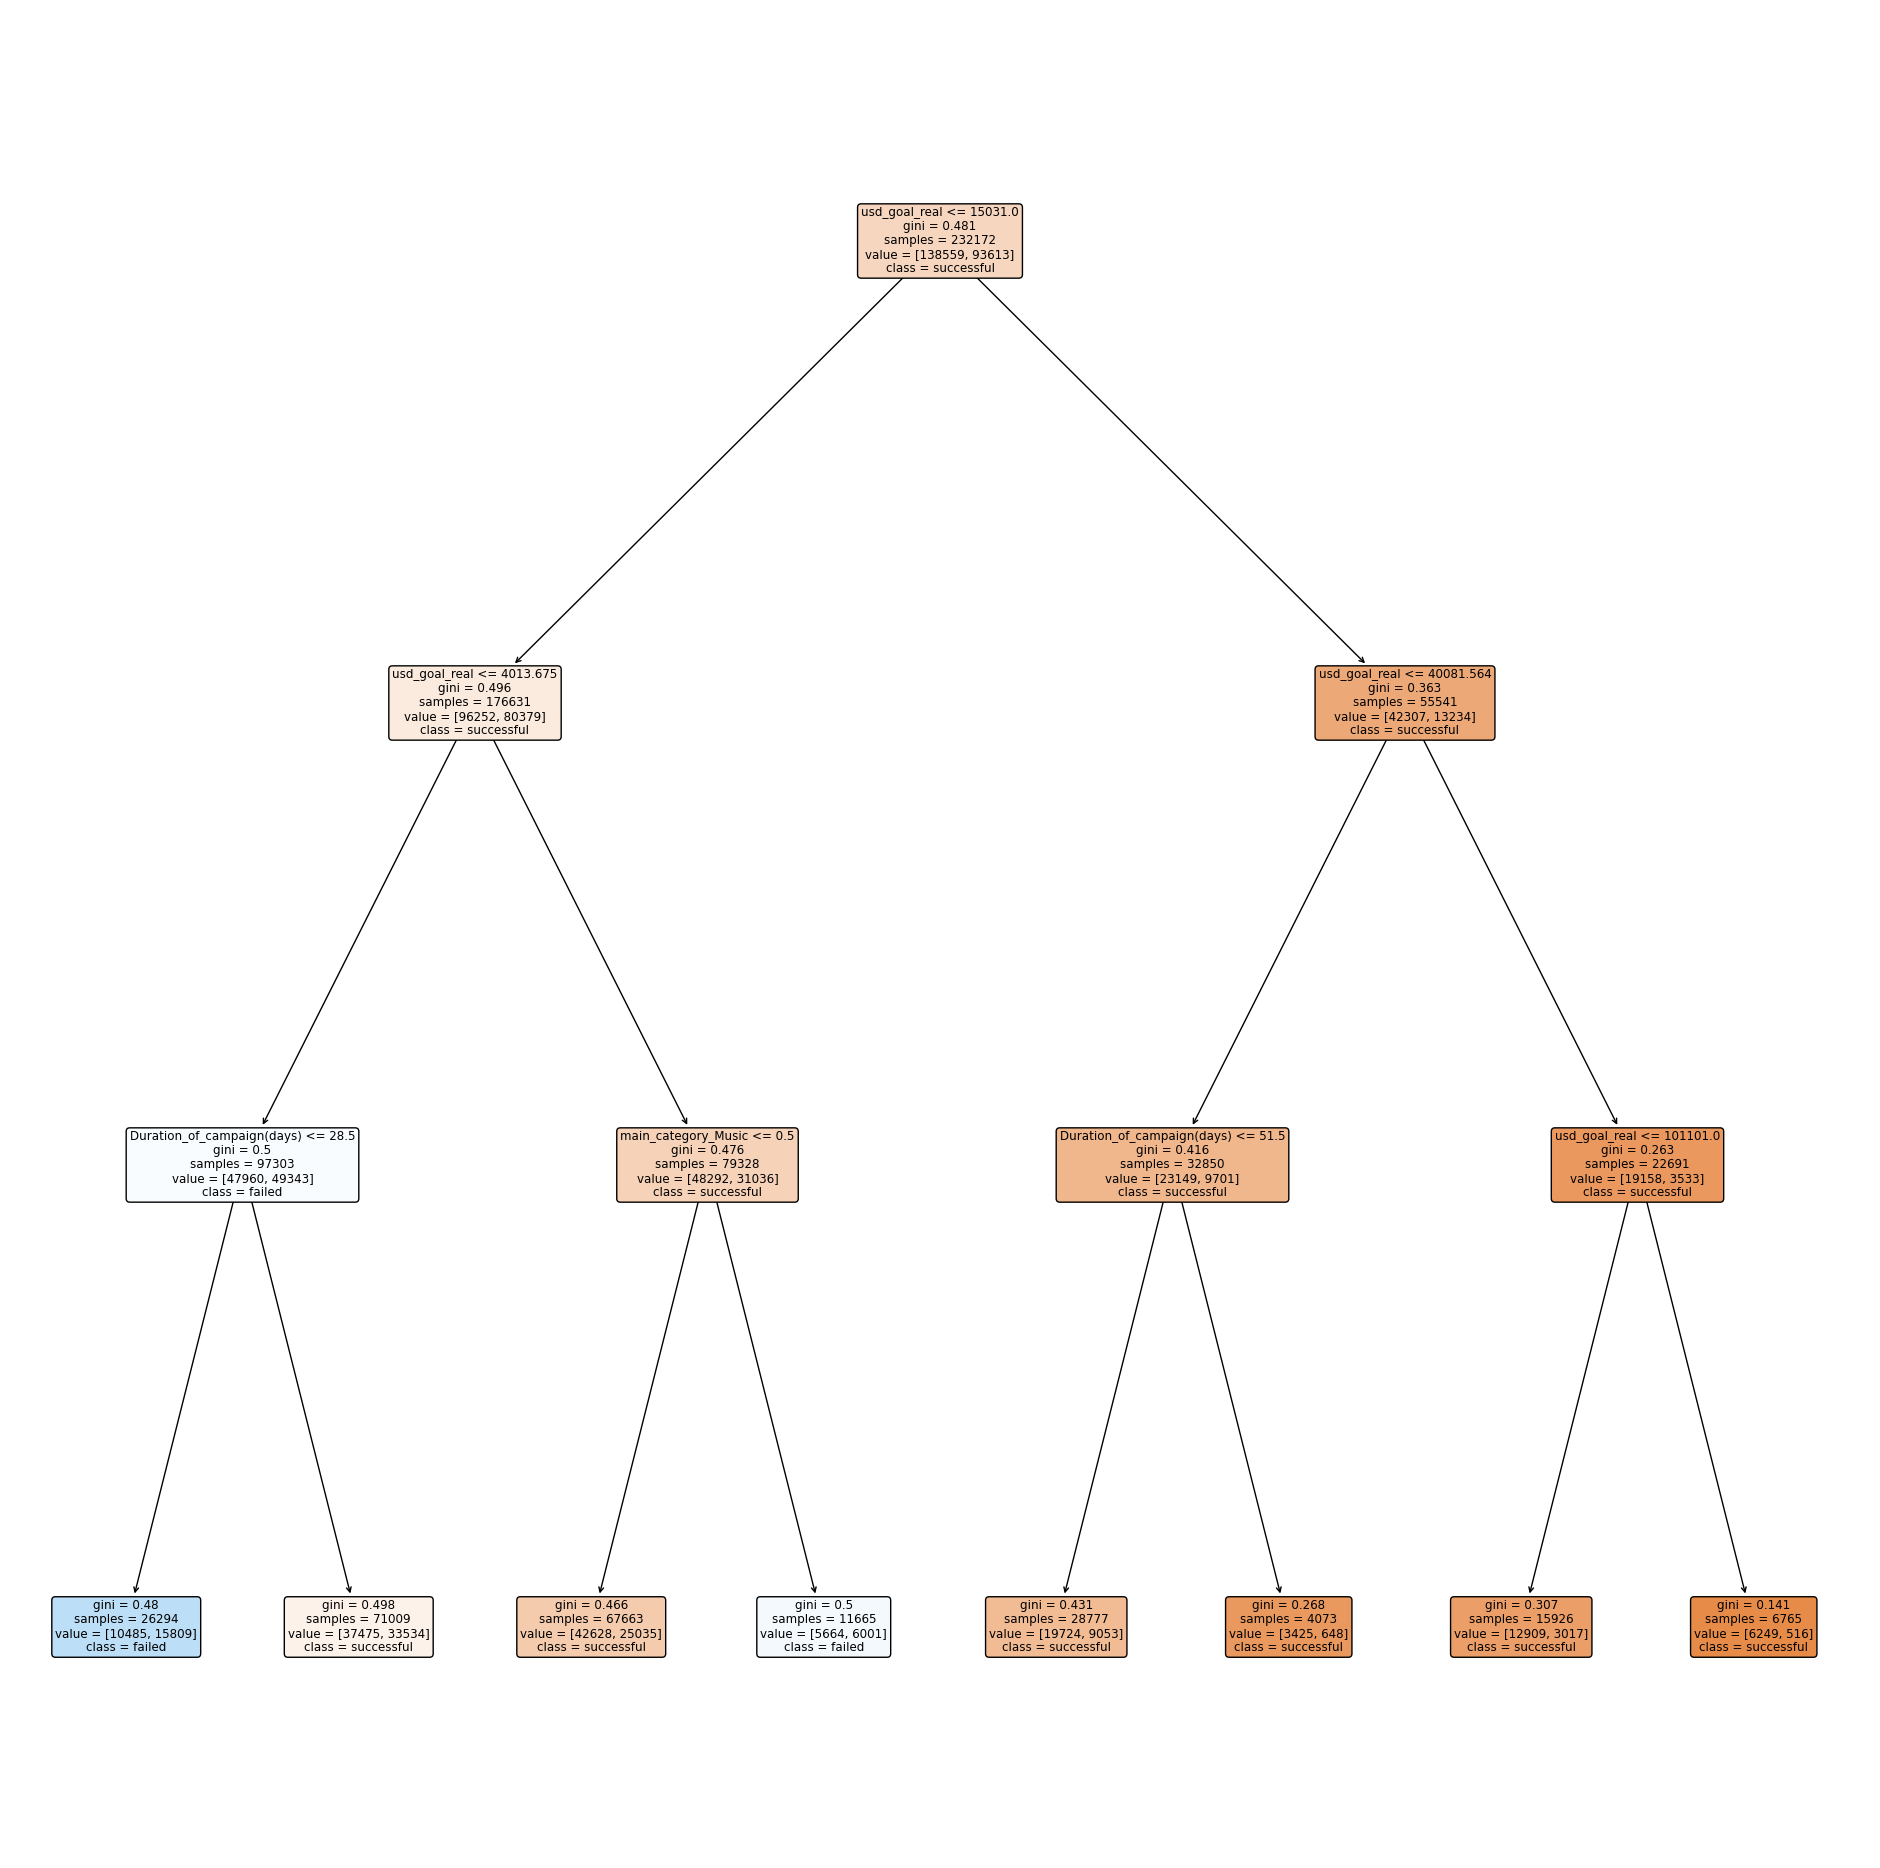

In [108]:
# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe["state"])
X = pd.DataFrame(model_data_ohe.drop("state", axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 3)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=list(X_train.columns), 
          class_names=["successful", "failed"]) #added list() to make it work

### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Train Data
Accuracy  :	 0.6211774029598746

TPR Train :	 0.2329804621153045
TNR Train :	 0.8834503713219639

FPR Train :	 0.11654962867803607
FNR Train :	 0.7670195378846955


<Axes: >

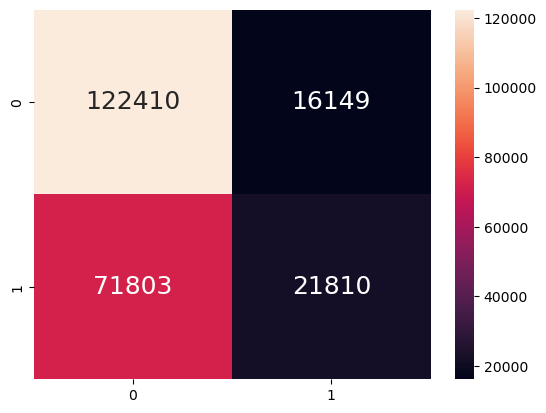

In [109]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.6206144538355628

TPR Test :	 0.23530724041345463
TNR Test :	 0.8833671399594321

FPR Test :	 0.11663286004056796
FNR Test :	 0.7646927595865454


<Axes: >

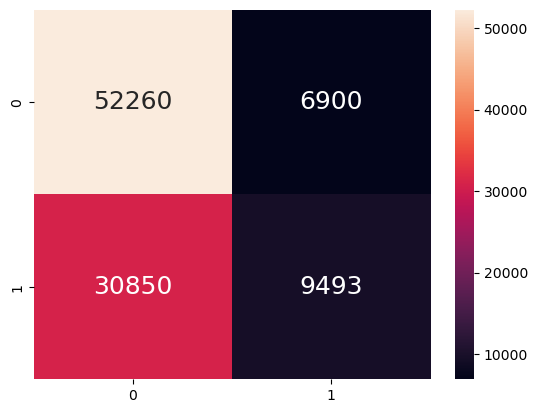

In [110]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})


## Create a Model for Rating : Attempt 2

**Important** : Note the huge imbalance in the *False Positives* and *False Negatives* in the confusion matrix. *False Negatives* are much higher in number than *False Positives* in both Train and Test data. This is not surprising -- actually, this is a direct effect of the large `failed` vs `success` class imbalance in the response variable `state`. As `state = failed` was more likely in the data, *False Negatives* are more likely too. Let's see if we can fix it.

Let's refine the previous model by balancing the classes of the response `state` in the training data. Keeping the OneHotEncoding same as before.

In [111]:
# Upsample good to match bad
from sklearn.utils import resample

failed = model_data_ohe[model_data_ohe.state == 'failed']
successful = model_data_ohe[model_data_ohe.state == 'successful']
 
# Upsample the Bad samples
successful_up = resample(successful, 
                        replace=True,                     # sample with replacement
                        n_samples=failed.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
model_data_ohe_up = pd.concat([successful_up,failed])
 
# Check the ratio of the classes
model_data_ohe_up['state'].value_counts()


successful    197719
failed        197719
Name: state, dtype: int64

### Create and Fit the Model

Finally, after the encoding and upsampling is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

[Text(0.5, 0.9, 'usd_goal_real <= 15031.0\ngini = 0.5\nsamples = 276806\nvalue = [138492, 138314]\nclass = successful'),
 Text(0.25, 0.7, 'usd_goal_real <= 4514.025\ngini = 0.495\nsamples = 214546\nvalue = [96137, 118409]\nclass = failed'),
 Text(0.125, 0.5, 'Duration_of_campaign(days) <= 28.5\ngini = 0.479\nsamples = 124398\nvalue = [49493, 74905]\nclass = failed'),
 Text(0.0625, 0.3, 'main_category_Fashion <= 0.5\ngini = 0.427\nsamples = 34643\nvalue = [10693, 23950]\nclass = failed'),
 Text(0.03125, 0.1, 'gini = 0.418\nsamples = 32873\nvalue = [9789, 23084]\nclass = failed'),
 Text(0.09375, 0.1, 'gini = 0.5\nsamples = 1770\nvalue = [904, 866]\nclass = successful'),
 Text(0.1875, 0.3, 'main_category_Fashion <= 0.5\ngini = 0.491\nsamples = 89755\nvalue = [38800, 50955]\nclass = failed'),
 Text(0.15625, 0.1, 'gini = 0.488\nsamples = 84963\nvalue = [35780, 49183]\nclass = failed'),
 Text(0.21875, 0.1, 'gini = 0.466\nsamples = 4792\nvalue = [3020, 1772]\nclass = successful'),
 Text(0.375

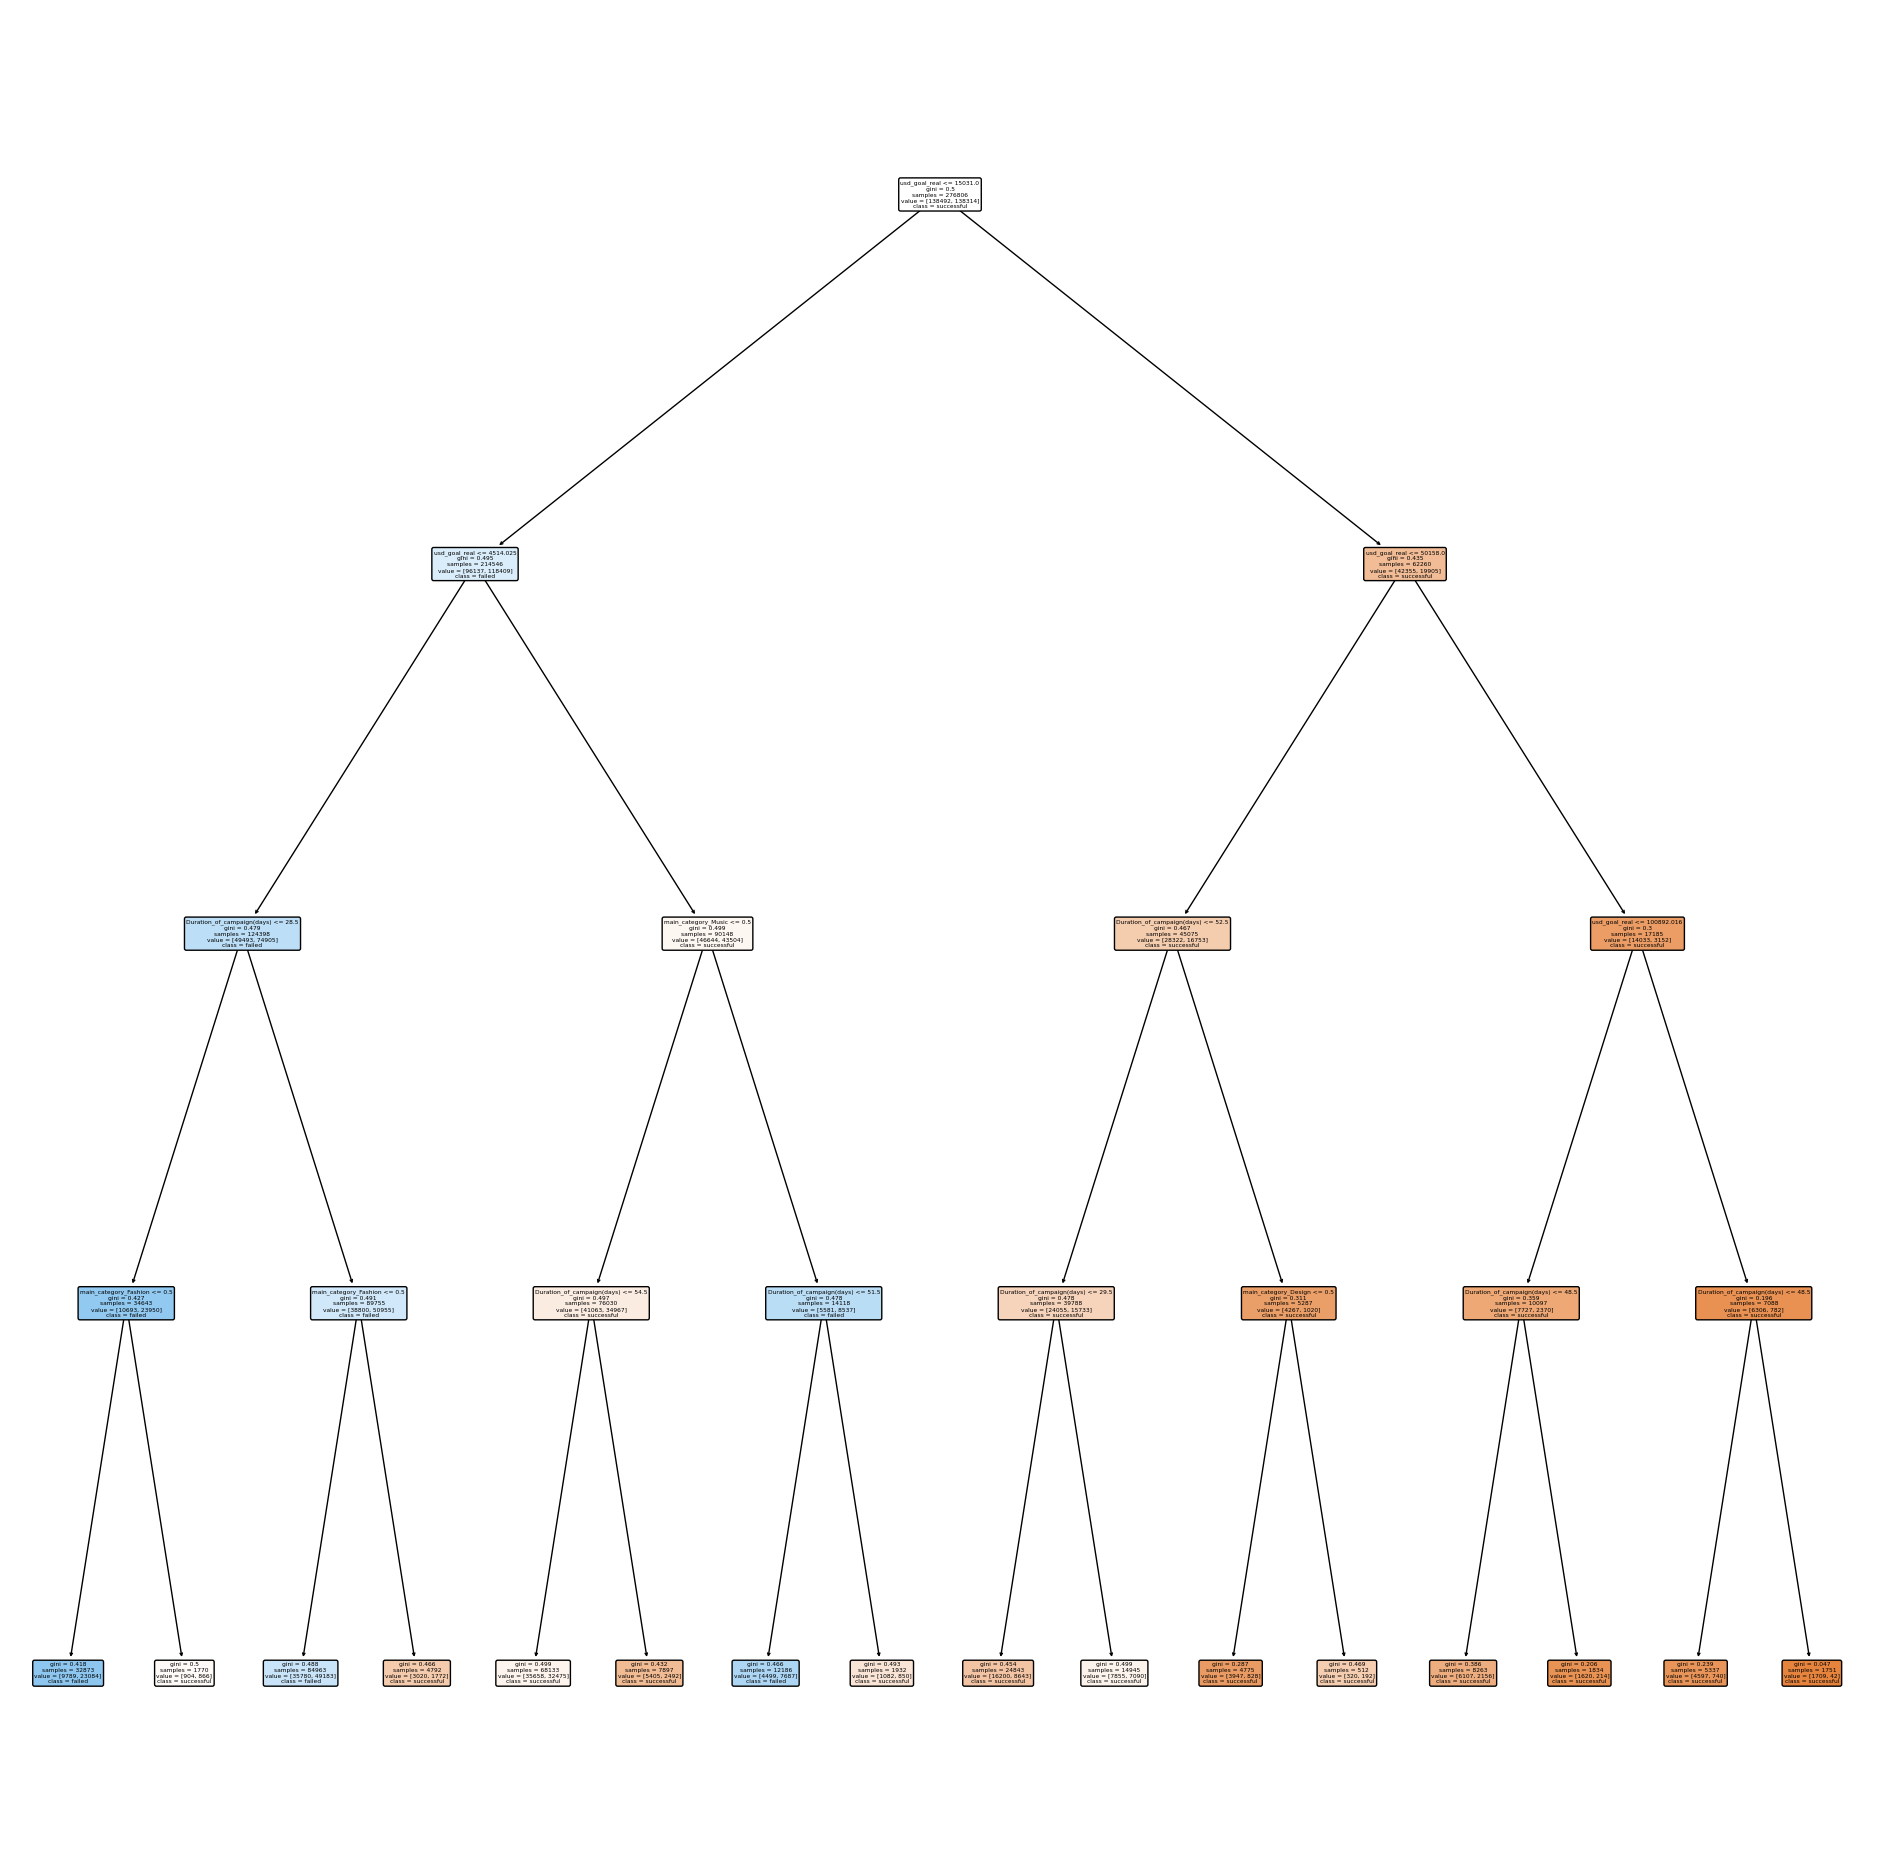

In [112]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=list(X_train.columns), 
          class_names=["successful", "failed"]) #added list() to make it work

### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Train Data
Accuracy  :	 0.6082888376697037

TPR Train :	 0.5780615122113452
TNR Train :	 0.6384773127689686

FPR Train :	 0.36152268723103137
FNR Train :	 0.4219384877886548


<Axes: >

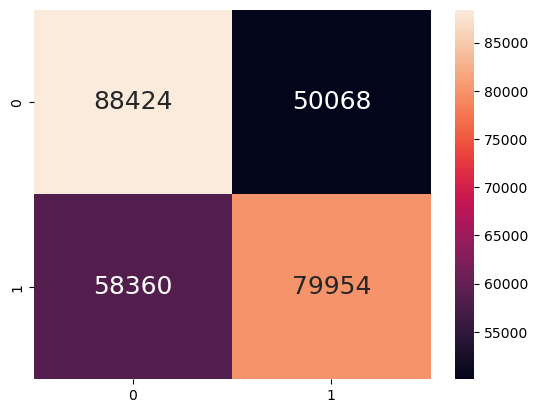

In [113]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.6067249983141142

TPR Test :	 0.5784361585725107
TNR Test :	 0.6350988569402468

FPR Test :	 0.36490114305975313
FNR Test :	 0.42156384142748926


<Axes: >

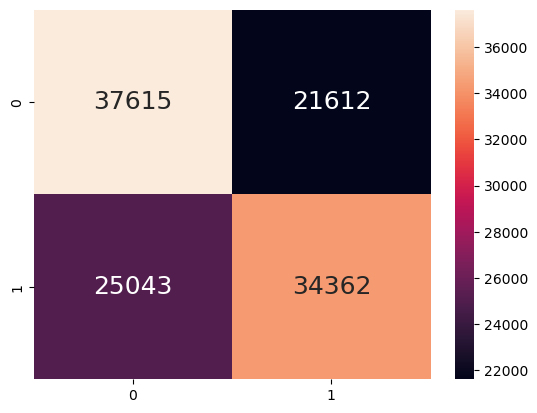

In [114]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

The false positives and false negatives seem more balanced now.

## Create a Model for Rating : Attempt 3

It is quite obvious that the Decision Tree is not doing too well, even after upsampling and encoding. It is time for us to move on to some other classifiers. Let's try another tree based classifier -- `RandomForest`, very close to Decision Tree in principle, but instead of a single tree, it uses an *ensemble* of trees for better classification. It is super-simple to find a new model in `sklearn`, read the documentation a little, and apply it immediately, as follows. Try it out!     

We will keep all the goodness of upsampling and encoding from our previous attempts, and thus, we will use the final dataset we created in the last attempt.

In [115]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split


# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))


# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [116]:
# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees # CHANGE AND EXPERIMENT
                                 max_depth = 4)       # set the maximum depth of each tree # CHANGE AND EXPERIMENT

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.state.ravel())

RandomForestClassifier(max_depth=4)

Train Data
Accuracy  :	 0.6296467562119318

TPR Train :	 0.7168701258338934
TNR Train :	 0.5424813469219713

FPR Train :	 0.45751865307802875
FNR Train :	 0.2831298741661065


<Axes: >

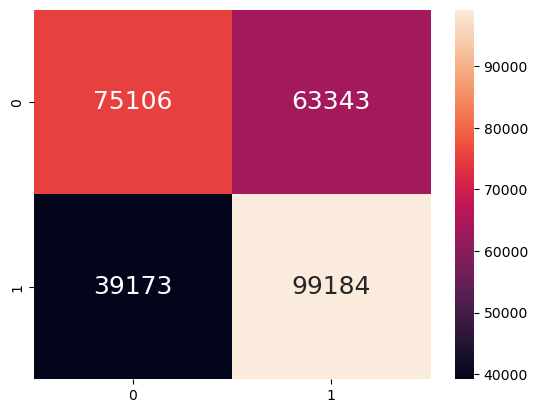

In [117]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.6293664441297457

TPR Test :	 0.717007513223948
TNR Test :	 0.541589336932681

FPR Test :	 0.45841066306731904
FNR Test :	 0.28299248677605204


<Axes: >

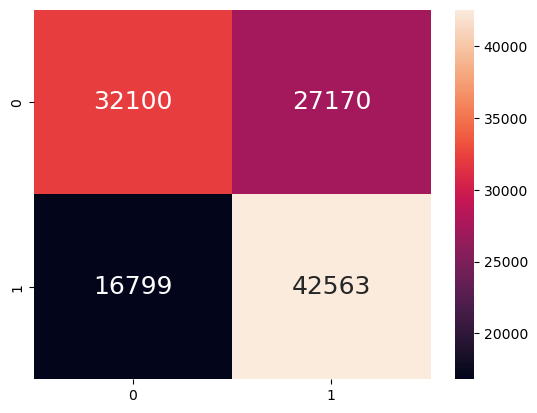

In [118]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

## Creating a Model for Rating : Attempt 4

Let's try out a basic set of tools for Cross-Validation, so that we can tune the Hyper-parameters of Random Forest in this case.

In [119]:
# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [120]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,201,100),   # number of trees 100,200..... 300
              'max_depth': np.arange(2,3)}             # depth of trees 2, 3, 4, 5....

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'f1')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.state.ravel())

C:\Users\a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "C:\Users\a\anacond

C:\Users\a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "C:\Users\a\anacond

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([2]),
                         'n_estimators': array([100, 200])},
             scoring='f1')

In [121]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=2)
nan


Note that the Cross-Validation routine is selecting the `best_estimator_` based on the `scoring` parameter of `accuracy`. You may change it to something else, if you want. For instance, `f1` score will be a good `scoring` strategy for binary classification. You may also choose to score your models by their `roc_auc` (Area Under the Receiver Operating Characteristic Curve) metric for a more balanced approach. Read more about these metrics.

### Use the Best Model found through GridSearchCV

In [122]:
# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 200,   # replace with best estimator found using GridSearchCV
                                 max_depth = 2)       # replace with best max depth found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.state.ravel())

RandomForestClassifier(max_depth=2, n_estimators=200)

Train Data
Accuracy  :	 0.6199576598773148

TPR Train :	 0.738186443863022
TNR Train :	 0.5018057321160291

FPR Train :	 0.49819426788397086
FNR Train :	 0.261813556136978


<Axes: >

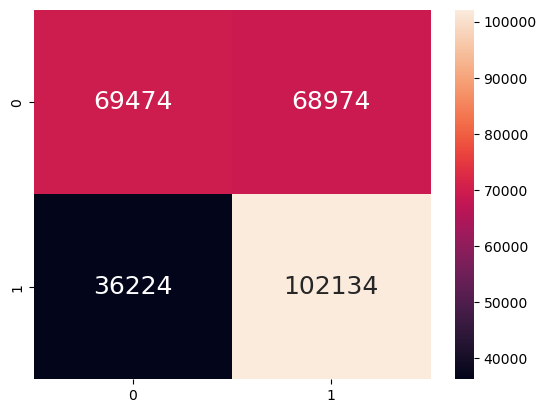

In [123]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.6202542315732686

TPR Test :	 0.7361735819814357
TNR Test :	 0.504158863525164

FPR Test :	 0.4958411364748359
FNR Test :	 0.2638264180185644


<Axes: >

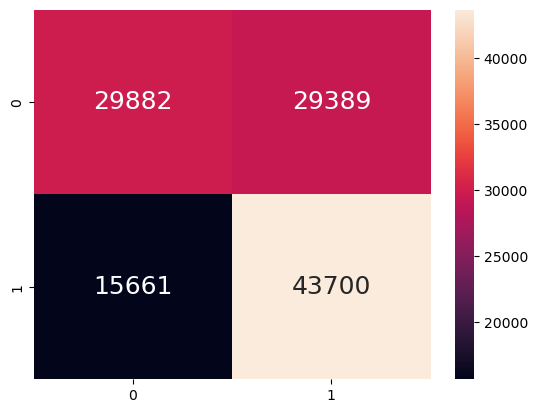

In [124]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

## XGB Classifier

In [143]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Transform both training and testing target variables
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit the model on the training data
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train_encoded)

# Predict on the test data
y_pred_xgb = xgbc.predict(X_test)

# Since the predictions are in encoded form, use the encoded y_test for evaluation
print("Confusion Matrix: \n", confusion_matrix(y_test_encoded, y_pred_xgb))
print("Accuracy Score for Test Set: ", accuracy_score(y_test_encoded, y_pred_xgb))

# Optionally, you might want to check accuracy on the training set
y_pred_train_xgb = xgbc.predict(X_train)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_encoded, y_pred_train_xgb))

C:\Users\a\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\a\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Confusion Matrix: 
 [[37375 21936]
 [18596 40725]]
Accuracy Score for Test Set:  0.6583383909906265
Accuracy Score for Training Set:  0.6679407238282408


In [159]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [4, 5],
    'min_child_weight': [5, 10],
    'subsample': [0.8, 1.0],
    'learning_rate': [0.01, 0.1]
}

xgb = XGBClassifier(verbosity=1)
grid_search = GridSearchCV(xgb, param_grid=params, scoring='accuracy', n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train_encoded)



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 5],
                         'min_child_weight': [5, 10], 'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [158]:
# Predict on the test data
y_pred_xgb = grid_search.predict(X_test)


# Since the predictions are in encoded form, use the encoded y_test for evaluation
print("Confusion Matrix: \n", confusion_matrix(y_test_encoded, y_pred_xgb))
print("Accuracy Score for Test Set: ", accuracy_score(y_test_encoded, y_pred_xgb))

Confusion Matrix: 
 [[37408 21903]
 [18938 40383]]
Accuracy Score for Test Set:  0.6557336974846585
